In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import scipy.integrate as scpi

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.adams_bashforth as ab
import cbmos.solvers.midpoint as md
import cbmos.solvers.heun as he
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

In [3]:
# calculate radius
def calculate_radius(cell_list):
    n_cells = len(cell_list)
    positions = np.array([cell.position for cell in cell_list])
    c = np.sum(positions, axis=0)/n_cells
    return 0.5 + max([np.linalg.norm(cell.position - c) for cell in cell_list])

In [4]:
# Simulation parameters
s = 1.0    # rest length
tf = 4.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2
#seed=17
seed = 67



In [5]:
#solver_names = ['EF', 'AB', 'midpoint', 'Heun']
solver_names = ['EF', 'midpoint', 'AB']
force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}
linestyles = {'cubic': '-', 'pw. quad.': '--', 'GLS': '-.'}


In [6]:
# Solvers
solvers_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
solvers_ab = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ab.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ab.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ab.solve_ivp, dim)}
solvers_he = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), he.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), he.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), he.solve_ivp, dim)}
solvers_md = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), md.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), md.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), md.solve_ivp, dim)}
#solver_dicts = {'EF': solvers_ef, 'AB': solvers_ab, 'midpoint': solvers_md, 'Heun': solvers_he}
solver_dicts = {'EF': solvers_ef, 'midpoint': solvers_md, 'AB': solvers_ab}

## Initial condition

In [7]:
# 2D honeycomb mesh
n_x = 5
n_y = 5
xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

# make cell_list for the sheet
sheet = [cl.Cell(i, [x,y], -6.0, True, lambda t: 6 + t) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]
# delete cells to make it circular
del sheet[24]
del sheet[20]
del sheet[19]
del sheet[9]
del sheet[4]
del sheet[0]

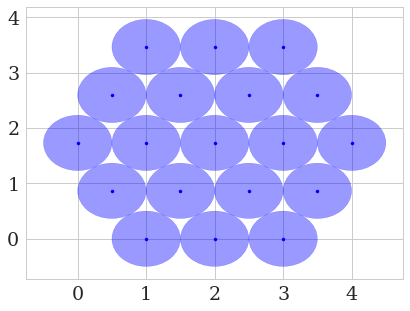

In [8]:
# plot to check what happend
plot_population(sheet)

In [9]:
#prepare consistent initial data
solver_scipy = cbmos.CBModel(ff.PiecewisePolynomial(), scpi.solve_ivp, dim)
t_data_init = [0, 0.0001]
_, initial_sheet = solver_scipy.simulate(sheet, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=seed)[-1]



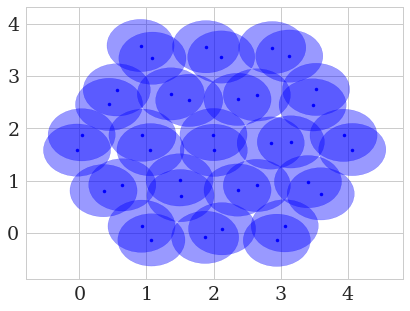

In [10]:
# plot to check what happend
plot_population(initial_sheet)

# Convergence study

## Using parameters fitted to relaxation time

In [11]:
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

In [12]:
dt_ref = 0.0005
N_ref = int(1/dt_ref*tf)+1
t_data_ref = np.arange(0, tf, dt_ref)

ref_sol_dicts = {}
for solver in solver_names:
    print(solver)
    solvers = solver_dicts[solver]
    ref_traj = {}
    for force in force_names: 
        print('>'+force)
        t_data_ref, history = solvers[force].simulate(initial_sheet, t_data_ref, params[force], {'dt': dt_ref}, seed=seed)
        ref_traj[force] = {
            cell.ID: np.array([cell_list[i].position for cell_list in history])
            for i, cell in enumerate(history[0])
        }
    ref_sol_dicts[solver] = ref_traj 
print('Done.')

EF
>cubic
>pw. quad.
>GLS
midpoint
>cubic
>pw. quad.
>GLS
AB
>cubic
>pw. quad.
>GLS
Done.


In [13]:
dt_values = [0.001*1.25**n for n in range(0, 22)]
sol_dicts = {}

In [14]:
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt*tf) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        t_data, history = solver_dicts['EF'][force].simulate(initial_sheet, t_data, params[force], {'dt': dt}, seed=seed)
        length = min(len(t_data), len(history))
        
        traj = {
            cell.ID: np.array([cell_list[i].position for cell_list in history])
            for i, cell in enumerate(history[0])
        }
                
        errorx = 0
        errory = 0
        for ID, tr in traj.items():
            interx = np.interp(t_data_ref[:], t_data[:length], tr[:length, 0])
            intery = np.interp(t_data_ref[:], t_data[:length], tr[:length, 1])
                        
            #splinex = CubicSpline(t_data[1:length], tr[:length, 0])
            #spliney = CubicSpline(t_data[1:length], tr[:length, 1])
            #interx = splinex(t_data_ref[1:])
            #intery = spliney(t_data_ref[1:])
            ref = ref_sol_dicts['EF'][force][ID]
            refx = ref[:,0]
            refy = ref[:,1]
            errorx = errorx + np.linalg.norm(interx-refx)/np.linalg.norm(refx)
            errory = errory + np.linalg.norm(intery-refy)/np.linalg.norm(refy)
        error = np.array([errorx, errory])/len(history[0])
        sol[force].append(error)
sol_dicts['EF'] = sol


[4001, 0.001]
[3201, 0.00125]
[2561, 0.0015625]
[2049, 0.001953125]
[1639, 0.00244140625]
[1311, 0.0030517578125]
[1049, 0.003814697265625]
[839, 0.00476837158203125]
[672, 0.0059604644775390625]
[537, 0.007450580596923828]
[430, 0.009313225746154785]
[344, 0.011641532182693481]
[275, 0.014551915228366852]
[220, 0.018189894035458565]
[176, 0.022737367544323206]
[141, 0.028421709430404007]
[113, 0.03552713678800501]
[91, 0.04440892098500626]
[73, 0.05551115123125783]
[58, 0.06938893903907228]
[47, 0.08673617379884035]
[37, 0.10842021724855044]


In [15]:
for force in force_names:
    print(np.sum(np.array(sol_dicts['EF'][force])[8,:]))

0.003513759616424259
0.004227756795482886
0.002313425822633452


In [16]:
for force in force_names:
    print(np.sum(np.array(sol_dicts['EF'][force])[-2,:]))

0.6585909758309734
0.3538224472685634
0.031173870428748307


In [17]:
for force in force_names:
    print(np.sum(np.array(sol_dicts['EF'][force])[-1,:]))

1.1737007848512233
0.37774972565648723
0.060337299952053836


In [18]:
#for dt, err in zip(dt_values,  sol_dicts['EF']['cubic']):
#    print([dt,err])
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force]) > 0.001)[0][0]]])

['cubic', 0.003814697265625]
['pw. quad.', 0.0030517578125]
['GLS', 0.00476837158203125]


In [19]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force]) > 0.01)[0][0]]])

['cubic', 0.028421709430404007]
['pw. quad.', 0.03552713678800501]
['GLS', 0.04440892098500626]


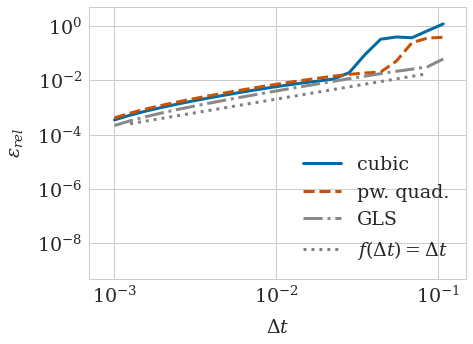

In [20]:
for force in force_names: 
    plt.loglog(dt_values, np.sum(np.array(sol_dicts['EF'][force]), axis=1), label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,1], label=force+' y')
plt.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
plt.legend(loc='lower right')
#plt.title('Euler forward')
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.xlim([7*1e-4, 1.5*1e-1])
plt.ylim([5*1e-10, 5*1e-0])

#plt.savefig('', bbox_inches='tight')
plt.savefig('38cells_convergence_EF.pdf', bbox_inches='tight')
plt.savefig('38cells_convergence_EF.eps', bbox_inches='tight')




In [21]:
current_solver = 'midpoint'
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt*tf) + 1
    #print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        t_data, history = solver_dicts[current_solver][force].simulate(initial_sheet, t_data, params[force], {'dt': dt}, seed=seed)
        length = min(len(t_data), len(history))
        
        traj = {
            cell.ID: np.array([cell_list[i].position for cell_list in history])
            for i, cell in enumerate(history[0])
        }
        
        errorx = 0
        errory = 0
        for ID, tr in traj.items():
            splinex = CubicSpline(t_data[:length], tr[:length, 0])
            spliney = CubicSpline(t_data[:length], tr[:length, 1])
            interx = splinex(t_data_ref[:])
            intery = spliney(t_data_ref[:])
            ref = ref_sol_dicts[current_solver][force][ID]
            refx = ref[:,0]
            refy = ref[:,1]
            errorx = errorx + np.linalg.norm(interx-refx)/np.linalg.norm(refx)
            errory = errory + np.linalg.norm(intery-refy)/np.linalg.norm(refy)
        error = np.array([errorx, errory])/len(history[0])
        sol[force].append(error)
sol_dicts[current_solver] = sol


In [22]:
#for dt, err in zip(dt_values,  sol_dicts['EF']['cubic']):
#    print([dt,err])
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['midpoint'][force]) > 0.001)[0][0]]])

['cubic', 0.018189894035458565]
['pw. quad.', 0.028421709430404007]
['GLS', 0.04440892098500626]


In [23]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['midpoint'][force]) > 0.01)[0][0]]])

['cubic', 0.04440892098500626]
['pw. quad.', 0.06938893903907228]
['GLS', 0.10842021724855044]


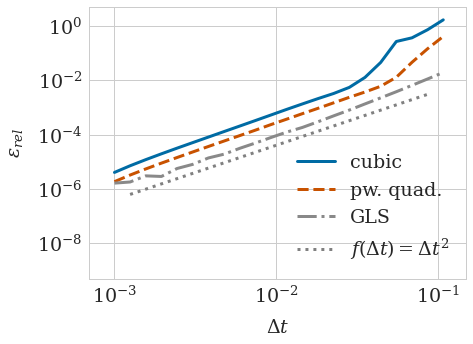

In [24]:
for force in force_names: 
    plt.loglog(dt_values, np.sum(np.array(sol_dicts['midpoint'][force]), axis=1), label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts[current_solver][force])[:,1], label=force+' y')
plt.loglog(dt_values[1:-1], np.array(dt_values[1:-1])**2*0.4, ':', label='$f(\Delta t)= \Delta t^2$', color='grey')
plt.legend()
#plt.title(current_solver)
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
#plt.savefig('', bbox_inches='tight')
plt.xlim([7*1e-4, 1.5*1e-1])
plt.ylim([5*1e-10, 5*1e-0])

plt.savefig('38cells_convergence_midpoint.pdf', bbox_inches='tight')
plt.savefig('38cells_convergence_midpoint.eps', bbox_inches='tight')



In [25]:
current_solver = 'AB'
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt*tf) + 1
    #print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        t_data, history = solver_dicts[current_solver][force].simulate(initial_sheet, t_data, params[force], {'dt': dt}, seed=seed)
        length = min(len(t_data), len(history))
        
        traj = {
            cell.ID: np.array([cell_list[i].position for cell_list in history])
            for i, cell in enumerate(history[0])
        }
        
        errorx = 0
        errory = 0
        for ID, tr in traj.items():
            splinex = CubicSpline(t_data[:length], tr[:length, 0])
            spliney = CubicSpline(t_data[:length], tr[:length, 1])
            interx = splinex(t_data_ref[:])
            intery = spliney(t_data_ref[:])
            ref = ref_sol_dicts[current_solver][force][ID]
            refx = ref[:,0]
            refy = ref[:,1]
            errorx = errorx + np.linalg.norm(interx-refx)/np.linalg.norm(refx)
            errory = errory + np.linalg.norm(intery-refy)/np.linalg.norm(refy)
        error = np.array([errorx, errory])/len(history[0])
        sol[force].append(error)
sol_dicts[current_solver] = sol


In [26]:
#for dt, err in zip(dt_values,  sol_dicts['EF']['cubic']):
#    print([dt,err])
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['AB'][force]) > 0.001)[0][0]]])

['cubic', 0.011641532182693481]
['pw. quad.', 0.014551915228366852]
['GLS', 0.022737367544323206]


In [27]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['AB'][force]) > 0.01)[0][0]]])

['cubic', 0.022737367544323206]
['pw. quad.', 0.04440892098500626]
['GLS', 0.08673617379884035]


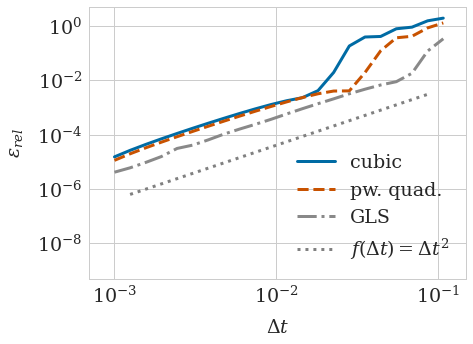

In [28]:
for force in force_names: 
    plt.loglog(dt_values, np.sum(np.array(sol_dicts['AB'][force]), axis=1), label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts[current_solver][force])[:,1], label=force+' y')
plt.loglog(dt_values[1:-1], np.array(dt_values[1:-1])**2*0.4, ':', label='$f(\Delta t)= \Delta t^2$', color='grey')
plt.legend()
#plt.title(current_solver)
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.xlim([7*1e-4, 1.5*1e-1])
plt.ylim([5*1e-10, 5*1e-0])
plt.savefig('38cells_convergence_AB.pdf', bbox_inches='tight')
plt.savefig('38cells_convergence_AB.eps', bbox_inches='tight')



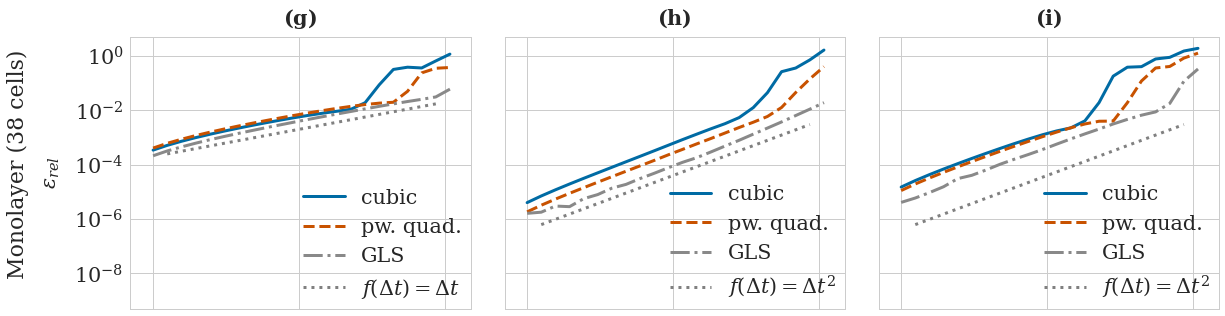

In [29]:
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 12,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)
# single figure

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(19.5, 5), sharey=True, gridspec_kw={'wspace': 0.1})

# ax1
for force in force_names: 
    
    ax1.loglog(dt_values, np.sum(np.array(sol_dicts['EF'][force]), axis=1), label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,1], label=force+' y')
ax1.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax1.legend(loc='lower right', borderaxespad=0.)
#plt.legend()
ax1.set_title(r'$\bf{(g)}$')
ax1.set(ylabel='$\epsilon_{rel}$')
ax1.set_xlim([7*1e-4, 1.5*1e-1])
ax1.set_ylim([5*1e-10, 5*1e-0])
ax1.set_xticklabels([])
#ax1.set_ylim([5*1e-8, 5*1e-0])
ax1.text(0.0001, 0.00000001, 'Monolayer (38 cells)', fontsize=22, rotation='vertical')

#ax2
for force in force_names: 
    ax2.loglog(dt_values, np.sum(np.array(sol_dicts['midpoint'][force]), axis=1), label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts[current_solver][force])[:,1], label=force+' y')
ax2.loglog(dt_values[1:-1], np.array(dt_values[1:-1])**2*0.4, ':', label='$f(\Delta t)= \Delta t^2$', color='grey')
ax2.legend(borderaxespad=0.)
#ax2.set(xlabel='$\Delta t$')
ax2.set_xlim([7*1e-4, 1.5*1e-1])
ax2.set_title(r'$\bf{(h)}$')
ax2.set_xticklabels([])

#ax2.text(0.0025, 150, 'midpoint method', fontsize=22)


#ax3
for force in force_names: 
    ax3.loglog(dt_values, np.sum(np.array(sol_dicts['AB'][force]), axis=1), label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts[current_solver][force])[:,1], label=force+' y')
ax3.loglog(dt_values[1:-1], np.array(dt_values[1:-1])**2*0.4, ':', label='$f(\Delta t)= \Delta t^2$', color='grey')
ax3.legend(borderaxespad=0.)
#ax3.set(xlabel='$\Delta t$')
ax3.set_xlim([7*1e-4, 1.5*1e-1])
ax3.set_title(r'$\bf{(i)}$')
ax3.set_xticklabels([])

#ax3.text(0.001, 150, 'Adams-Bashforth method', fontsize=22)


plt.savefig('Fig13c_combined.pdf', bbox_inches='tight')

plt.loglog(0.005*np.ones((10,1)), np.linspace(10^-5, 2*10^0, 10),':', color='grey', alpha=0.5)
plt.loglog(0.075*np.ones((10,1)), np.linspace(10^-5, 10^0, 10), ':', color='grey', alpha=0.5)
linestyles = {'EF': '-', 'midpoint': '--', 'AB': '-.'}
for solver in ['EF', 'midpoint']:
    for force in force_names: 
        plt.loglog(dt_values, np.sum(np.array(sol_dicts[solver][force]), axis=1), color=colors[force], linestyle=linestyles[solver])
    #plt.loglog(dt_values, np.array(sol_dicts[current_solver][force])[:,1], label=force+' y')
plt.loglog(dt_values[2:-6], np.array(dt_values[2:-6])*4, '-', label='$f(\Delta t)= \Delta t$', color='grey')
plt.loglog(dt_values[2:-6], np.array(dt_values[2:-6])**2*0.2, '--', label='$f(\Delta t)= \Delta t^2$', color='grey')
plt.ylim([0.00000001, 2])
plt.legend()
#plt.title(current_solver)
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.savefig('convergence_38cells_ef_md.pdf', bbox_inches='tight')
plt.savefig('convergence_38cells_ef_md.png', bbox_inches='tight')

In [30]:
-2*np.log(0.002/mu_gls)

13.764874941995695